## Градиентный бустинг

### Предварительная обработка данных

In [56]:
import pandas as pd

# Загрузка данных
sales_train = pd.read_csv('sales_train.csv')

# Идентификация и удаление строк с очевидными выбросами
sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_cnt_day'] < sales_train['item_cnt_day'].quantile(0.99))]
sales_train = sales_train[sales_train['item_price'] > sales_train['item_price'].quantile(0.01)]  # Исключаем распродажи по очень низкой цене

# Преобразование даты
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

# Расчет двухнедельных и месячных периодов для каждого года
sales_train['year'] = sales_train['date'].dt.year
sales_train['two_week_period'] = sales_train['date'].dt.isocalendar().week // 2 + 1
sales_train['month'] = sales_train['date'].dt.month
sales_train['date_block_week'] = sales_train['year'].astype(str) + '_' + sales_train['two_week_period'].astype(str)
sales_train['date_block_month'] = sales_train['year'].astype(str) + '_' + sales_train['month'].astype(str)

# Расчет средних значений за двухнедельные и месячные периоды
mean_prices_weekly = sales_train.groupby(['item_id', 'date_block_week'])['item_price'].mean().reset_index()
mean_sales_weekly = sales_train.groupby(['item_id', 'date_block_week'])['item_cnt_day'].mean().reset_index()
mean_prices_monthly = sales_train.groupby(['item_id', 'date_block_month'])['item_price'].mean().reset_index()
mean_sales_monthly = sales_train.groupby(['item_id', 'date_block_month'])['item_cnt_day'].mean().reset_index()

# Присоединяем средние цены и количество продаж обратно к основным данным
sales_train = sales_train.merge(mean_prices_weekly, on=['item_id', 'date_block_week'], suffixes=('', '_mean_week'))
sales_train = sales_train.merge(mean_sales_weekly, on=['item_id', 'date_block_week'], suffixes=('', '_mean_week'))
sales_train = sales_train.merge(mean_prices_monthly, on=['item_id', 'date_block_month'], suffixes=('', '_mean_month'))
sales_train = sales_train.merge(mean_sales_monthly, on=['item_id', 'date_block_month'], suffixes=('', '_mean_month'))

# Фильтрация данных
sales_train['price_diff'] = abs(sales_train['item_price'] - sales_train['item_price_mean_week']) / sales_train['item_price_mean_week']
filtered_data = sales_train[sales_train['price_diff'] > 0.05]

In [57]:
filtered_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,two_week_period,month,date_block_week,date_block_month,item_price_mean_week,item_cnt_day_mean_week,item_price_mean_month,item_cnt_day_mean_month,price_diff
25,2013-01-24,0,4,2564,349.0,1.0,2013,3,1,2013_3,2013_1,322.25,1.0,327.600000,1.000000,0.083010
26,2013-01-28,0,0,2564,242.0,1.0,2013,3,1,2013_3,2013_1,322.25,1.0,327.600000,1.000000,0.249030
27,2013-01-29,0,41,2564,349.0,1.0,2013,3,1,2013_3,2013_1,322.25,1.0,327.600000,1.000000,0.083010
30,2013-01-04,0,25,2572,239.0,1.0,2013,1,1,2013_1,2013_1,284.00,1.0,284.333333,1.000000,0.158451
31,2013-01-01,0,14,2572,299.0,1.0,2013,1,1,2013_1,2013_1,284.00,1.0,284.333333,1.000000,0.052817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854335,2015-10-24,33,25,3457,1299.0,1.0,2015,22,10,2015_22,2015_10,1949.00,1.0,2165.666667,1.000000,0.333504
2854353,2015-10-17,33,28,5338,1299.0,1.0,2015,22,10,2015_22,2015_10,1374.00,1.0,1374.000000,1.000000,0.054585
2854354,2015-10-24,33,25,5338,1449.0,1.0,2015,22,10,2015_22,2015_10,1374.00,1.0,1374.000000,1.000000,0.054585
2854874,2015-10-16,33,25,13653,1199.0,1.0,2015,22,10,2015_22,2015_10,1049.05,1.5,1099.033333,1.333333,0.142939


### Обучим модель

In [69]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Загрузка данных
train_data = pd.read_csv('filtered_sales_train.csv')
data_items = pd.read_csv('items.csv')
train_data = pd.merge(train_data, data_items, on=['item_id'])
train_data = train_data.drop(columns=['item_name', 'date_block_week','date_block_month', 'price_diff', 'date_block_num'])

# Преобразование столбца даты
train_data['date'] = pd.to_datetime(train_data['date'])  # Убрали параметр format

# Сортировка по дате
train_data.sort_values(by='date', inplace=True)

# Разделение данных на обучающий и тестовый наборы
cutoff_index = int(len(train_data) * 0.9)
train, test = train_data.iloc[:cutoff_index], train_data.iloc[cutoff_index:]

# Подготовка данных
X_train = train.drop(['item_cnt_day', 'date'], axis=1)
y_train = train['item_cnt_day']
X_test = test.drop(['item_cnt_day', 'date'], axis=1)
y_test = test['item_cnt_day']

# Нормализация числовых признаков (item_price)
scaler = StandardScaler()
X_train['item_price'] = scaler.fit_transform(X_train[['item_price']])
X_test['item_price'] = scaler.transform(X_test[['item_price']])

# Обучение модели
cat_features = ['shop_id', 'item_id', 'item_category_id']
model = CatBoostRegressor(iterations=1800, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=200, task_type="GPU")
model.fit(X_train, y_train, cat_features=cat_features)

# Оценка модели
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')

0:	learn: 0.3851381	total: 16.9ms	remaining: 30.4s
200:	learn: 0.3384399	total: 3.7s	remaining: 29.4s
400:	learn: 0.3342405	total: 7.47s	remaining: 26.1s
600:	learn: 0.3314424	total: 11.3s	remaining: 22.5s
800:	learn: 0.3292403	total: 15.2s	remaining: 18.9s
1000:	learn: 0.3271555	total: 19s	remaining: 15.2s
1200:	learn: 0.3253444	total: 22.9s	remaining: 11.4s
1400:	learn: 0.3237797	total: 26.8s	remaining: 7.64s
1600:	learn: 0.3222349	total: 30.9s	remaining: 3.84s
1799:	learn: 0.3207380	total: 34.9s	remaining: 0us
MSE: 0.13617654537387858, MAE: 0.16677453258232322, R^2: 0.28696792138435934


### Оценим результаты

                   Features  Importance
7    item_cnt_day_mean_week   26.659876
2                item_price   20.029564
0                   shop_id   15.016563
9   item_cnt_day_mean_month   11.711184
10         item_category_id    8.717268
1                   item_id    6.035298
6      item_price_mean_week    4.301165
8     item_price_mean_month    3.038336
4           two_week_period    2.801027
5                     month    1.145735
3                      year    0.543981


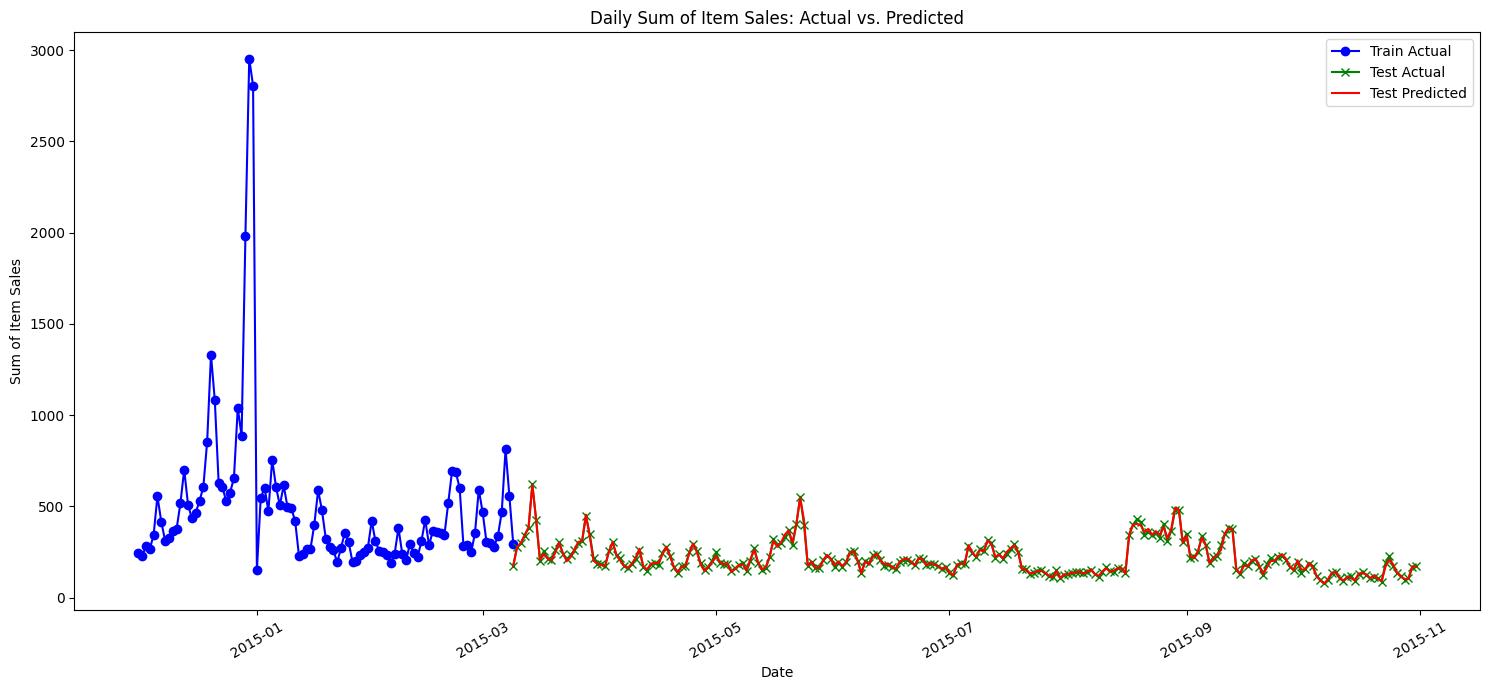

In [70]:
import matplotlib.pyplot as plt

# Вывод важности признаков
feature_importances = model.get_feature_importance()
features = X_train.columns
importance_sales_train = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print(importance_sales_train)


# Группировка данных по дням
train_new= train[train['date'] >= '2014-12-01']
train_grouped = train_new.groupby('date')['item_cnt_day'].sum()
test_grouped = test.groupby('date')['item_cnt_day'].sum()

# Предсказания для тестового набора данных
predictions_series = pd.Series(predictions, index=test.index)

# Группировка предсказаний по дням
predicted_grouped = test.assign(predicted_item_cnt=predictions_series).groupby('date')['predicted_item_cnt'].sum()

# График сравнения группированных данных
plt.figure(figsize=(15, 7))

# Построение графиков
plt.plot(train_grouped.index, train_grouped.values, label='Train Actual', color='blue', marker='o')
plt.plot(test_grouped.index, test_grouped.values, label='Test Actual', color='green', marker='x')
plt.plot(predicted_grouped.index, predicted_grouped.values, label='Test Predicted', color='red', linestyle='-')

plt.title('Daily Sum of Item Sales: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Sum of Item Sales')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
